## This notebook is for an example of how to use XCast for Canonical Correlation Analysis (CCA) based for Determinisitc and Probabilisitc  forecast.

In this example using one NMME model and CHIRPS data as reference for preciptation forecast for East Africa

Created by Nachiketa Acharya on Dec,2023

Reference:

Acharya et al., 2021;https://www.sciencedirect.com/science/article/pii/S2405880721000601





### Import Librarires

In [1]:
import xcast as xc 
import xarray as xr 
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


print('XCAST VERSION: ', xc.__version__)

XCAST VERSION:  0.6.9


### Read downloded Observed data


Read your donwloded or own observed data. For example, I have donwloeded CHIRPS(Oct-Nov-Dec avaergare from 1982-2021 for 5S-25N,15E-55E)Y 
from IRI DL using the below link.However,anyone can donwloded data from any webpage
data downlowed from IRI data library link :https://iridl.ldeo.columbia.edu/SOURCES/.UCSB/.CHIRPS/.v2p0/.daily-improved/.global/.0p25/.prcp/T/%28Jan%201982%29/%28Dec%202022%29/RANGE/T/%28Oct-Dec%29/seasonalAverage/Y/%285S%29/%2825N%29/RANGEEDGES/X/%2815E%29/%2855E%29/RANGEEDGES/#expert

In [2]:
obs = xr.open_dataset('CHIRPS_OND_1982_2021.nc',decode_times=False).prcp.expand_dims({'M':[0]},axis=1)#As XCast handle only 4 dimesion data, we need to add one extra dimesion in Observed data. Here, we add "M" dimension in second axis. This is only for data downloded from IRI Data library as they have this issue
obs.dims

('T', 'M', 'Y', 'X')

### Read downloded NMME data

Read your donwloded NMME data from anywhere.For example, I have donwloeded CFS and CCSM4 hindcast data(lead -1,Sep Start Oct-Nov-Dec avaergare from 1982-2021 for 5S-25N,15E-55E)and forecast (lead -1,Sep Start Oct-Nov-Dec avaergare for 2023)  from IRI DL using the below links.However,anyone can donwloded data from any webpage data downlowed from IRI data library link

data downlowed links :

CFS hindcast: https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/a:/.HINDCAST/.PENTAD_SAMPLES/.MONTHLY/.prec/:a:/.FORECAST/.PENTAD_SAMPLES/.MONTHLY/.prec/:a/appendstream/S/%280000%201%20Sep%201982-2021%29/VALUES/L/0.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/Y/%285S%29/%2825N%29/RANGEEDGES/X/%2815E%29/%2855E%29/RANGEEDGES/M/%281%29/%2824%29/RANGE/%5BM%5Daverage/index.html#expert

CFS forecast: https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.FORECAST/.PENTAD_SAMPLES/.MONTHLY/.prec/S/%280000%201%20Sep%202023%29/VALUES/L/0.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/Y/%285S%29/%2825N%29/RANGEEDGES/X/%2815E%29/%2855E%29/RANGEEDGES/%5BM%5Daverage/#expert


In [3]:
##reading Hindcast

Model_hindcast = xr.open_dataset('CFSv2_SepIC_OND_1982_2021_prc_EA.nc',decode_times=False).prec

Model_hindcast= Model_hindcast.rename({'L':'M'})
#model1.dims

##reading Forecast

Model_forecast = xr.open_dataset('CFSv2_SepIC_OND_2023_prc_EA.nc',decode_times=False).prec

Model_forecast= Model_forecast.rename({'L':'M'})
#model1.dims

### Match the resolution of Model and Observed data

In [4]:
Model_hindcast = xc.regrid(Model_hindcast,obs.X,obs.Y)
Model_forecast = xc.regrid(Model_forecast,obs.X,obs.Y)

### Dry Mask

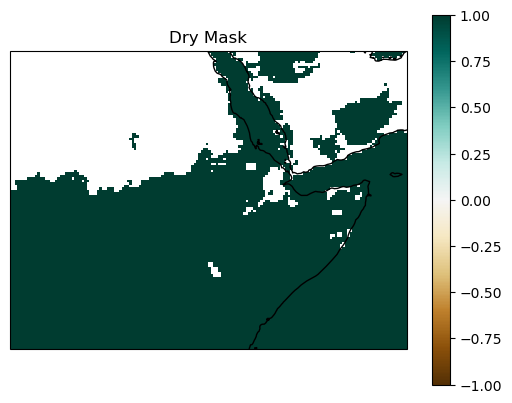

In [10]:
#The way this function works is 1/ compute the quantile indicated by 'quantile_threshold' (must be within (0,1)  2/ call gridpoints 'dry' if that computed quantile is less than the continuous 'dry_threshold'.  So the below code calls a gridpoint dry if its 90th percentile is < 0.001. I think thats equivalent to "at least 10 % of the data is > 0". 
drymask = xc.drymask(obs, dry_threshold=.1, quantile_threshold=0.1)# >10% of the data below 0.1
dplot = drymask.plot(subplot_kws={'projection': ccrs.PlateCarree()},vmin=-1,vmax=1,cmap='BrBG')
art = dplot.axes.coastlines()
art1= dplot.axes.set_title('Dry Mask')

Model_hindcast=Model_hindcast*drymask
Model_forecast=Model_forecast*drymask

## Fitting CCA in hindcast by cross validation

#### define hyperparameter

In [19]:
est_kwargs = {
    'xmodes':(1, 3), 
    'ymodes':(1, 3), 
    'ccamodes':(1,3),
    #'search_override': (3,3,2), # if someone hard code the xmode, ymode and cca mode instead of all the combiantions
    #'eof_modes': 15, # only for PCR - comment out for CCA 
    'latitude_weighting': True,
    
    
}


#### Run fitting

In [20]:
hindcasts_det, hindcasts_prob = [], []
i=1
for xtrain, ytrain, xtest, ytest in xc.CrossValidator(Model_hindcast, obs, window=1):
    print("window {}".format(i))
    i += 1
    reg = xc.CCA(**est_kwargs)
    reg.fit(xtrain, ytrain)
    probs =  reg.predict_proba(xtest)
    preds = reg.predict(xtest)
    hindcasts_det.append(preds.isel(S=0))
    hindcasts_prob.append(probs.isel(S=0))
hindcasts_det = xr.concat(hindcasts_det, 'S')
hindcasts_prob = xr.concat(hindcasts_prob, 'S')

window 1
window 2
window 3
window 4
window 5
window 6
window 7
window 8
window 9
window 10
window 11
window 12
window 13
window 14
window 15
window 16
window 17
window 18
window 19
window 20
window 21
window 22
window 23
window 24
window 25
window 26
window 27
window 28
window 29
window 30
window 31
window 32
window 33
window 34
window 35
window 36
window 37
window 38
window 39
window 40


#### Smooth the hindcast and observed data 

In [21]:
hindcasts_det=xc.gaussian_smooth(hindcasts_det, kernel=3)
hindcasts_prob=xc.gaussian_smooth(hindcasts_prob, kernel=3)
obs=xc.gaussian_smooth(obs, kernel=3)

#### Saving a 4d netcdf data

In [22]:
MME_temp_OND=hindcasts_det.squeeze('M')
MME_temp_OND_hindcasts = MME_temp_OND.rename({'X': 'longitude', 'Y': 'latitude'})
MME_temp_OND_hindcasts.to_netcdf('hindcast_OND_CCA_CFSv2_prec.nc') 


### Calculate skill metircs

#### Pearson Correlation

UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample', 'feature']


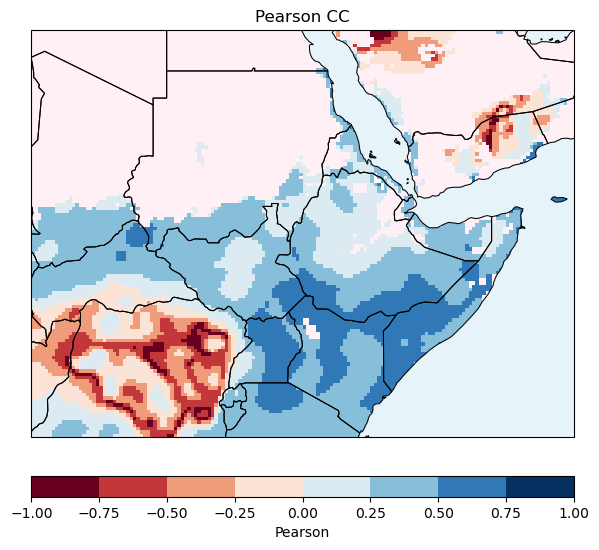

In [24]:
pearson = xc.Pearson(hindcasts_det, obs)
pl=xc.view(pearson,drymask=drymask,title='Pearson CC',cmap=plt.get_cmap('RdBu',8),vmin=-1,vmax=1)

#### Index of Agreement

UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample', 'feature']


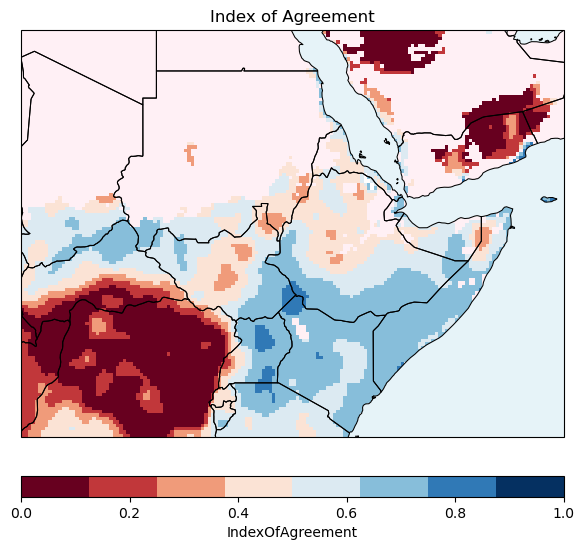

In [25]:
IOA = xc.IndexOfAgreement(hindcasts_det, obs)
pl=xc.view(IOA,drymask=drymask,title='Index of Agreement',cmap=plt.get_cmap('RdBu',8),vmin=0,vmax=1)

#### Kling Gupta Efficiency

UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample', 'feature']


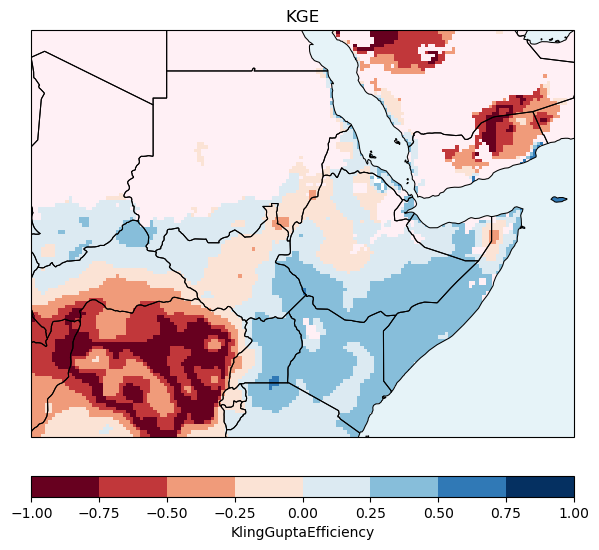

In [26]:
KGE = xc.KlingGuptaEfficiency(hindcasts_det, obs)
pl=xc.view(KGE,drymask=drymask,title='KGE',cmap=plt.get_cmap('RdBu',8),vmin=-1,vmax=1)

#### Generalized ROC Score

UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample', 'feature']


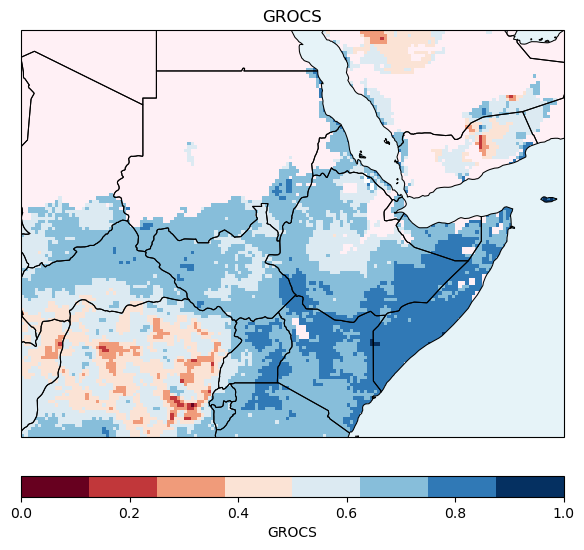

In [27]:
ohc = xc.OneHotEncoder() 
ohc.fit(obs)
T = ohc.transform(obs)
clim = xr.ones_like(T) * 0.333

groc=xc.GROCS(hindcasts_prob, T)
pl=xc.view(groc,drymask=drymask,title='GROCS',cmap=plt.get_cmap('RdBu',8),vmin=0,vmax=1)

#### Rank Probability Skill Score

UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample', 'feature']


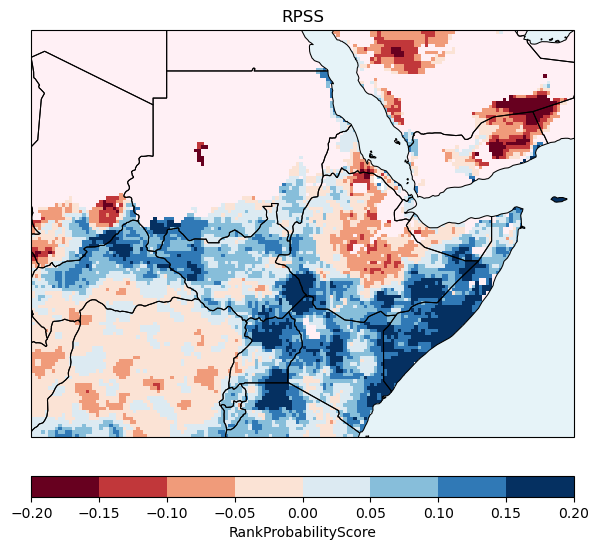

In [28]:
clim_rps = xc.RankProbabilityScore(clim, T)
pred_rps = xc.RankProbabilityScore(hindcasts_prob, T)
rpss = 1 - pred_rps / clim_rps

pl=xc.view(rpss,drymask=drymask,title='RPSS',cmap=plt.get_cmap('RdBu',8),vmin=-0.2,vmax=0.2)


####  ROC plot

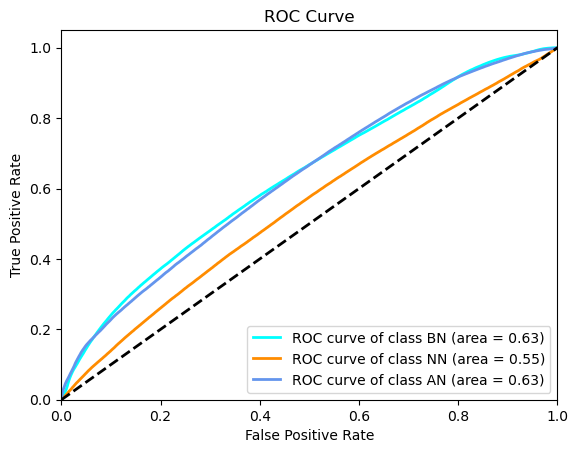

In [29]:
xc.view_roc( hindcasts_prob, T )

#### Reliability plot

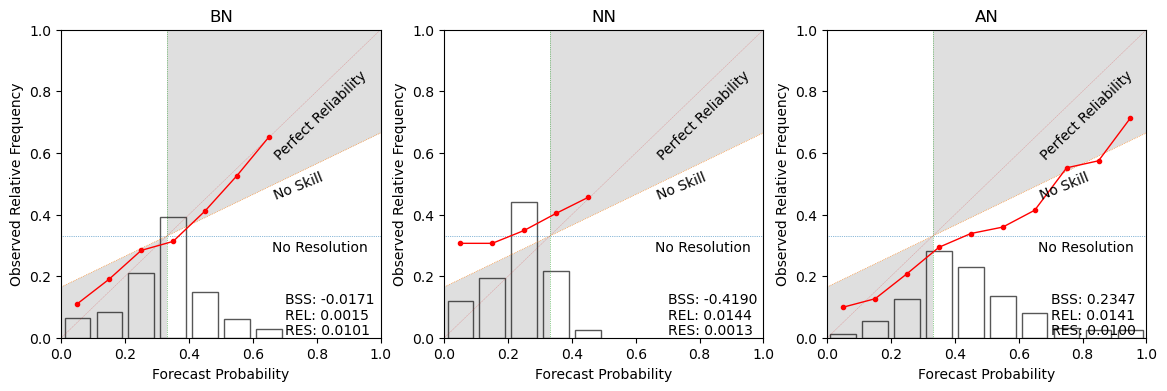

In [30]:
xc.view_reliability( hindcasts_prob, T )

### Generation of Forecast

In [31]:
#running forecasts

reg = xc.CCA(**est_kwargs)
reg.fit(Model_hindcast, obs)
preds = reg.predict(Model_forecast)
probs = reg.predict_proba(Model_forecast)


    
#smoothing
forecasts_det_smooth=xc.gaussian_smooth(preds, kernel=9)
forecasts_prob_smooth=xc.gaussian_smooth(probs, kernel=9)


##Anomaly
forecasts_det_smooth_anomaly=forecasts_det_smooth-hindcasts_det.mean('S')




# saving files
forecasts_det_smooth.to_netcdf('forecasts_deterministic.nc')
forecasts_det_smooth_anomaly.to_netcdf('forecasts_anomaly.nc')
forecasts_prob_smooth.to_netcdf('forecasts_tercile.nc')



### Plotting

UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample', 'feature']
UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample']


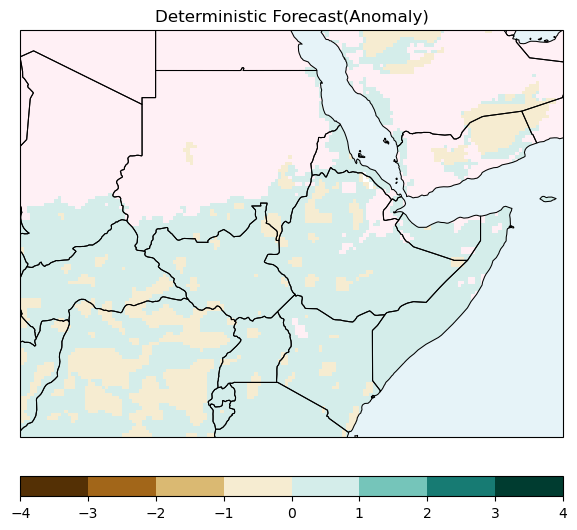

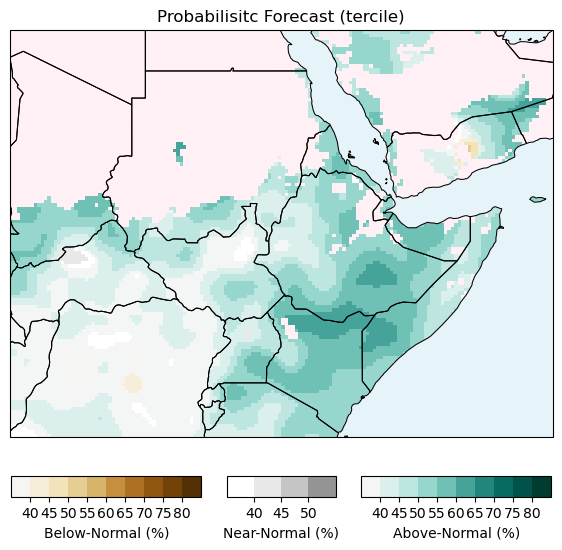

In [32]:

xc.view(forecasts_det_smooth_anomaly.isel(S=0,M=0),drymask=drymask,title='Deterministic Forecast(Anomaly)',cmap=plt.get_cmap('BrBG',8),vmin=-4, vmax=4,)

xc.view_probabilistic(forecasts_prob_smooth.isel(S=0),title='Probabilisitc Forecast (tercile)',drymask=drymask)


### Forecasts for Extreme

UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample', 'feature']


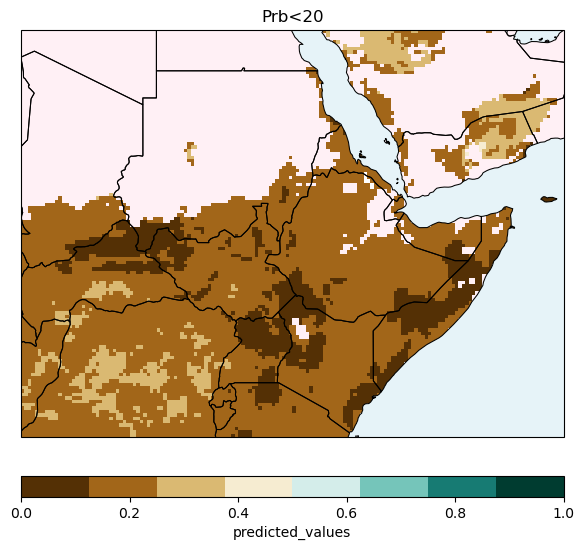

In [33]:
prob20 = reg.predict_proba(Model_forecast, quantile=0.2)
pl=xc.view(prob20.squeeze(),drymask=drymask,title='Prb<20',cmap=plt.get_cmap('BrBG',8),vmin=0,vmax=1)

UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample', 'feature']


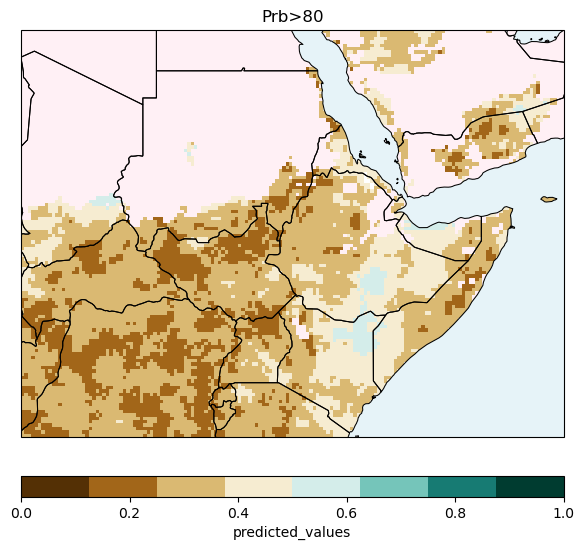

In [34]:
prob80 = 1-reg.predict_proba(Model_forecast, quantile=0.8)
pl=xc.view(prob80.squeeze(),drymask=drymask,title='Prb>80',cmap=plt.get_cmap('BrBG',8),vmin=0,vmax=1)